# Sentiment Analysis of Drug Reviews & Sentiment Prediction of Reviews

## Team Members: Snehal Lokesh, Sushanth Sreenivasa Babu, Sushma Mahadevaswamy

Patient reviews on specific drugs, as well as linked ailments, are included in the dataset, as well as a 10-star patient rating indicating overall patient satisfaction. Crawling online pharmaceutical review sites yielded the information. The goal was to do research.

* drug experience sentiment analysis across multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects
* model transferability across domains, i.e. conditions, and 
* model transferability across different data sources (see 'Drug Review Dataset (Druglib.com)').

Ref: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

We intend to analyze the sentiment on a scale of "Positive," "Negative," and "Neutral" by looking at the various reviews for each condition and drug. We first investigate the data, then process it as needed, extract some insights using NLP approaches, and then model our data to anticipate review outcomes.

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from textblob import TextBlob
from  sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pdb 
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from gensim import matutils, models
import scipy.sparse
from sklearn.feature_extraction import text 
from bs4 import BeautifulSoup
# from wordcloud import WordCloud
import tqdm
from textblob import TextBlob, Word, Blobber
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 1. Exploratory Data Analysis

We initially import the data into a pandas DataFrame and attempt to further analyze it. We can see that the condition column has 899 "NaN" values.

Further investigation reveals that these columns contain relevant drug names but no conditions; a look at the histogram reveals that the majority of these have a very low useful count. As a result, we decide to remove these rows before continuing with the study.

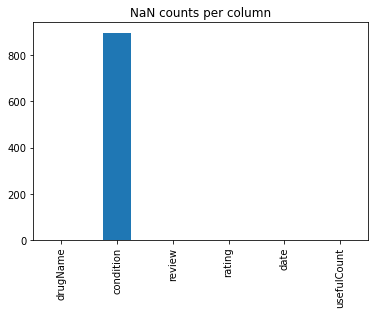

In [2]:
# NaN counts per column
data = pd.read_csv("./drugsComTrain_raw.tsv",  index_col=False, sep='\t')
data.drop(['Unnamed: 0'], axis=1, inplace=True) # drop Unnamed: 0 column
data.isnull().sum().plot(kind='bar')
plt.title("NaN counts per column")
plt.show() 

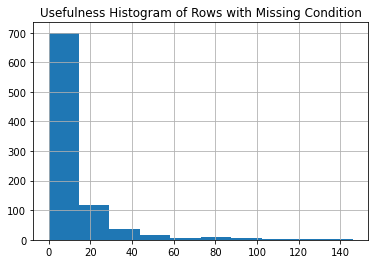

In [3]:
# Nan usefulness
data[data['condition'].isnull()]['usefulCount'].hist()
plt.title("Usefulness Histogram of Rows with Missing Condition")
plt.show()

In [4]:
data.dropna(axis=0, inplace=True) # dropping NaN rows
data.head()

drugName                     condition  \
0                 Valsartan  Left Ventricular Dysfunction   
1                Guanfacine                          ADHD   
2                    Lybrel                 Birth Control   
3                Ortho Evra                 Birth Control   
4  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

Now we can see that the data has 160K rows and 6 columns, with the column data types listed below. This will aid us in furthering our analysis and determining the best course of action.

In [5]:
print("Shape of the data:" , data.shape)

Shape of the data: (160398, 6)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     160398 non-null  object 
 1   condition    160398 non-null  object 
 2   review       160398 non-null  object 
 3   rating       160398 non-null  float64
 4   date         160398 non-null  object 
 5   usefulCount  160398 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 8.6+ MB


The rating column appears to be largely positive at first glance, with a greater number of rows with a rating of greater than 8. However, there appear to be a significant number of columns with a "1" rating.

Text(0.5, 1.0, 'Reviews per Rating')

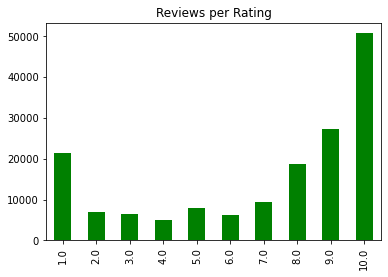

In [7]:
pd.Categorical(data['rating']).value_counts().plot(kind='bar', color = 'green')
plt.title("Reviews per Rating")

Text(0.5, 1.0, 'Drugs for the most number of conditions')

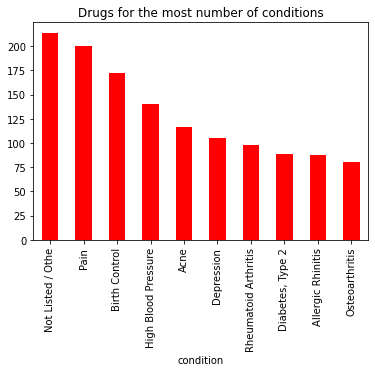

In [8]:
condition = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition[0:10].plot(kind="bar", color="red")
plt.title("Drugs for the most number of conditions")

Further examination reveals rows containing the phrase ' <//span> users considered this comment helpful.' This could be a data gathering error that needs to be addressed. We decided to remove these rows from our analysis because their mean helpful rating is just about 11.

In [9]:
data[data['condition'].str.contains('</span> users found this comment helpful.', 
                                    na=False)]['usefulCount'].mean()

11.311111111111112

In [10]:
data.drop(data[data['condition'].str.contains('</span> users found this comment helpful.')].index,
          axis=0, inplace=True) # drop rows

Let's take a look at our review column and see how we can improve our text processing pipeline. We can look at a few of the reviews and see how they are portrayed.

It appears that the text data contains some special characters that need to be eliminated, and the crawling process has resulted in the substitution of * /&#039 * for '. We'll have to deal with these during the cleaning procedure.

In [11]:
data['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In [12]:
data['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

We'll now look at the review column and apply our NLP approaches to eliminate stopwords and clean up the data with regular expressions. This will aid us in determining which terms are most closely related to the review's sentiment.

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords.remove('no')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "willnot", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"\"", "", phrase)
    phrase = re.sub(r"&#039;", "\'", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [15]:
# Combining all the above reviews 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)
        sent = re.sub(r"http\S+", "", sentence)
        sent = BeautifulSoup(sentence, 'lxml').get_text()
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [16]:
preprocessed_review = preprocess_text(data['review'].values)
data['processed_review'] = preprocessed_review

100%|██████████| 159498/159498 [00:44<00:00, 3560.41it/s]


In [17]:
def sentiment(rating):

    if rating >= 7:
        return 'Positive'

    elif 4 < rating < 7:
        return 'Neutral'

    elif rating <= 4:
        return 'Negative'

<AxesSubplot:>

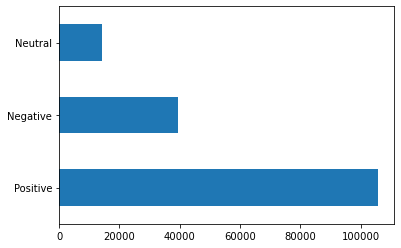

In [18]:
data['ratings_labels'] = data['rating'].apply(sentiment)
data['ratings_labels'].value_counts().plot(kind='barh')

The top 5 drugs with a specific sentiment for a specific condition are discovered. These can be chosen from a dropdown menu.

In [19]:
import ipywidgets as widgets

def plot_top_positive_rated_drugs(condition, sentiment):
    temp = data[(data['condition'] == condition) & (data['ratings_labels'] == sentiment)].groupby(['drugName', 
                                                                                                    'ratings_labels'], as_index=False).agg({"ratings_labels": "count"})
    temp = temp.nlargest(n=10, 
                         columns=['ratings_labels'], 
                         keep='all').sort_values('ratings_labels', ascending=False)
    temp.head()
    temp.plot(kind='barh',y='ratings_labels', x='drugName')

condition = widgets.Dropdown(options=data.condition.unique().tolist(),
                             description="Condition", value='ADHD')
sentiment = widgets.Dropdown(options=data.ratings_labels.unique().tolist(), 
                             description="Sentiment", value='Positive') 
@widgets.interact(Condition = condition, Sentiment = sentiment)
def widget_plotter(Condition, Sentiment):
    plot_top_positive_rated_drugs(Condition, Sentiment)

interactive(children=(Dropdown(description='Condition', index=1, options=('Left Ventricular Dysfunction', 'ADH…

We're now looking for words that appear frequently in each of the labels.

We started with unigrams and discovered that these words appear in all three lables. Then we go on to bigrams, trigrams, and finally 4-grams. The majority of these phrases appear to be intuitively linked with their associated sentiment.

In [20]:
from collections import defaultdict

df_positive = data[data['ratings_labels'] == "Positive"]
df_negative = data[data['ratings_labels'] == "Negative"]
df_neutral = data[data['ratings_labels'] == "Neutral"]

In [21]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

# Reference: https://www.kaggle.com/code/chocozzz/recommendation-medicines-by-using-a-review#2.-Date-Preprocessing

def plot_grams(gram_size, gram_text):
## custom function for ngram generation ##
    def generate_ngrams(text, gram_size):
        token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
        ngrams = zip(*[token[i:] for i in range(gram_size)])
        return [" ".join(ngram) for ngram in ngrams]

    ## custom function for horizontal bar chart ##
    def horizontal_bar_chart(df, color):
        trace = go.Bar(
            y=df["word"].values[::-1],
            x=df["wordcount"].values[::-1],
            showlegend=False,
            orientation = 'h',
            marker=dict(
                color=color,
            ),
        )
        return trace

    ## Function to get the bar chart
    def get_bar_chart(df):
        freq_dict = defaultdict(int)
        for sent in df["processed_review"]:
            for word in generate_ngrams(sent, gram_size):
                freq_dict[word] += 1
        fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
        fd_sorted.columns = ["word", "wordcount"]
        trace = horizontal_bar_chart(fd_sorted.head(20), 'blue')
        return trace

    ## Get the bar chart for positive
    trace0 = get_bar_chart(df_positive)

    ## Get the bar chart for negative
    trace1 = get_bar_chart(df_negative)

    ## Get the bar chart for neutral
    trace2 = get_bar_chart(df_neutral)

    # Creating three subplots
    fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                              subplot_titles=["Frequent "+gram_text+": Positive", 
                                              "Frequent "+gram_text+": Negative",
                                              "Frequent "+gram_text+": Neutral"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 2, 1)
    fig.append_trace(trace2, 3, 1)
    fig['layout'].update(height=1200, width=900)
    py.iplot(fig, filename='word-plots')

N-grams are a documents continuous sequence of words or symbols. With example, for n = 1, these are called unigrams and represent single words in a text, as illustrated in the chart below. While n = 2 is written as a pair of words such as "birth control" and "side effects," n = 2 is represented as a bigram. n = 3 is also referred to as trigrams.

Below chart shows the top unigrams words occured in the entire corpus for each label category

In [22]:
plot_grams(1, "unigrams")

/Users/sushanthsreenivasa/opt/anaconda3/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Below chart shows the top bigrams words occured in the entire corpus for each label category

In [23]:
plot_grams(2, "bi-grams")

/Users/sushanthsreenivasa/opt/anaconda3/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Below chart shows the top trigrams occured in the entire corpus for each label category

In [24]:
plot_grams(3, "tri-grams")

Below chart shows the top trigrams occured in the entire corpus for each label category

In [25]:
plot_grams(4, "4-grams")

We can now examine the words and phrases our three labels have in common. Before we begin modeling our data and obtaining metrics, we may now complete our pretreatment tasks.

In [26]:
data.head()

drugName                     condition  \
0                 Valsartan  Left Ventricular Dysfunction   
1                Guanfacine                          ADHD   
2                    Lybrel                 Birth Control   
3                Ortho Evra                 Birth Control   
4  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  \
0       May 20, 2012           27   
1     April 27, 2010          192   
2  December 14, 2009           17   
3   November 3, 2015           10   
4  November 27, 2016           37   

                                    processed_review ratings_labels  
0  no side effect take combination bystolic 5 mg ...       Positive  
1  son halfway fourth week intuniv became concern...       Positive  
2  used take another oral contraceptive 21 pill c...        Neutral  
3  first time using form birth control glad went ...       Positive  
4  suboxone completely turned life around feel he...       Positive

### 2. Feature Engineering & Data Preprocessing

The columns "review," "rating," and "date" can be removed because they offer no value to our data. We'll go on without these columns for now.

While the rating column already fulfills this function, the vader package provides sentiment for a given paragraph. This can be used as a feature to enhance our prediction. Let's look at the vader values now.

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
data['vader_scores'] = data['processed_review'].apply(lambda review: sid.polarity_scores(review))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [28]:
def get_score_neg(x):
    return x['neg']

def get_score_neu(x):
    return x['neu']

def get_score_pos(x):
    return x['pos']

data['vader_neg'] = data['vader_scores'].apply(get_score_neg)
data['vader_pos'] = data['vader_scores'].apply(get_score_pos)
data['vader_neu'] = data['vader_scores'].apply(get_score_neu)

In [29]:
def vader_label(x, y, z):
    if (x > y) & (x > z):
        return "Negative"
    elif (y > z) & (y > x):
        return "Positive"
    else:
        return "Neutral"
    
data['vader_polarity'] = data.apply(lambda x: vader_label(x['vader_neg'], x['vader_pos'], x['vader_neu']), axis=1)

We'll look at how the vader features effect our sentiment labels now that we've developed them.

<AxesSubplot:>

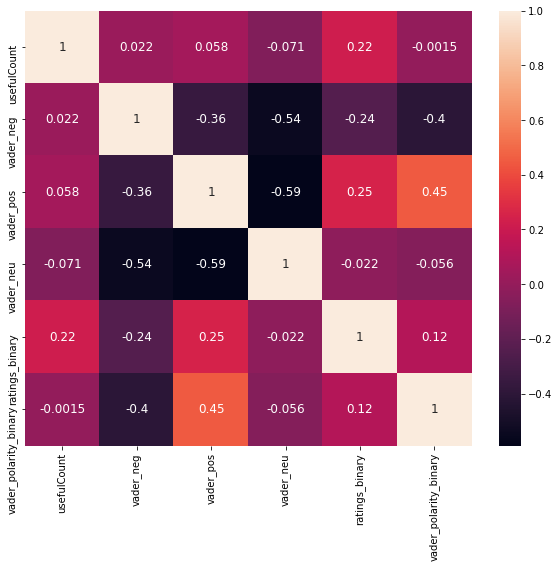

In [30]:
data['ratings_binary'] = data['ratings_labels'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data['vader_polarity_binary'] = data['vader_polarity'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

plt.subplots(figsize=(10,8))
sns.heatmap(data[['usefulCount', 'vader_neg', 
                  'vader_pos', 'vader_neu', 'ratings_binary', 'vader_polarity_binary']].corr(),
           annot=True, annot_kws={"size": 12})

Despite the fact that the ratings label and the Vader scores have a very little association, there appears to be a greater overall score than the rest. As a result, we'll maintain these for modeling purposes.

In [31]:
# Selecting columns required for modeling
df_model = data[['drugName', 'condition', 'usefulCount', 'processed_review', 
                 'vader_neg', 'vader_pos', 'vader_neu', 'ratings_binary', 'ratings_labels']]

As a word preprocessing step, we now perform stemming and lemmatization for our data.

In [32]:
st = PorterStemmer()
df_model['processed_review'] = df_model['processed_review'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df_model['processed_review'] = df_model['processed_review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [33]:
df_model.head()

drugName                     condition  usefulCount  \
0                 Valsartan  Left Ventricular Dysfunction           27   
1                Guanfacine                          ADHD          192   
2                    Lybrel                 Birth Control           17   
3                Ortho Evra                 Birth Control           10   
4  Buprenorphine / naloxone             Opiate Dependence           37   

                                    processed_review  vader_neg  vader_pos  \
0    no side effect take combin bystol 5 mg fish oil      0.216      0.000   
1  son halfway fourth week intuniv becam concern ...      0.035      0.209   
2  use take anoth oral contracept 21 pill cycl ha...      0.087      0.125   
3  first time use form birth control glad went pa...      0.044      0.178   
4  suboxon complet turn life around feel healthie...      0.109      0.302   

   vader_neu  ratings_binary ratings_labels  
0      0.784               1       Positive  
1      0.756               1       Positive  
2      0.788               0        Neutral  
3      0.778               1       Positive  
4      0.589               1       Positive

We try to convert the text-only drugName and condition columns to numeric format as an exploratory step. As a result, the model's emotion prediction isn't only based on these two columns.

Condition weights is a feature that counts the number of various drugs connected with a condition, while drugName weights is a feature that counts the number of different conditions associated with a specific drug. However, before modeling, we need look at how they relate to our goal.

In [34]:
condition_weights = {}

for condition in df_model['condition'
                         ].unique():
    condition_weights[condition] = df_model[df_model['condition'] == condition]['drugName'].nunique()

In [35]:
drugName_weights = {}

for drugName in df_model['drugName'].unique():
    drugName_weights[drugName] = df_model[df_model['drugName'] == drugName]['condition'].nunique()

In [36]:
df_model['drugName_weights'] = df_model['drugName'].map(drugName_weights)
df_model['condition_weights'] = df_model['condition'].map(condition_weights)

In [37]:
df_model.columns

Index(['drugName', 'condition', 'usefulCount', 'processed_review', 'vader_neg',
       'vader_pos', 'vader_neu', 'ratings_binary', 'ratings_labels',
       'drugName_weights', 'condition_weights'],
      dtype='object')

<AxesSubplot:>

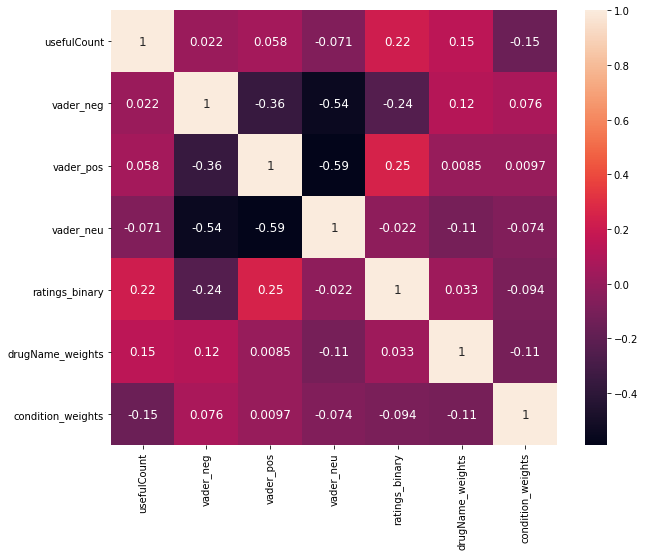

In [38]:
plt.subplots(figsize=(10,8))
sns.heatmap(df_model.corr(),
           annot=True, annot_kws={"size": 12})

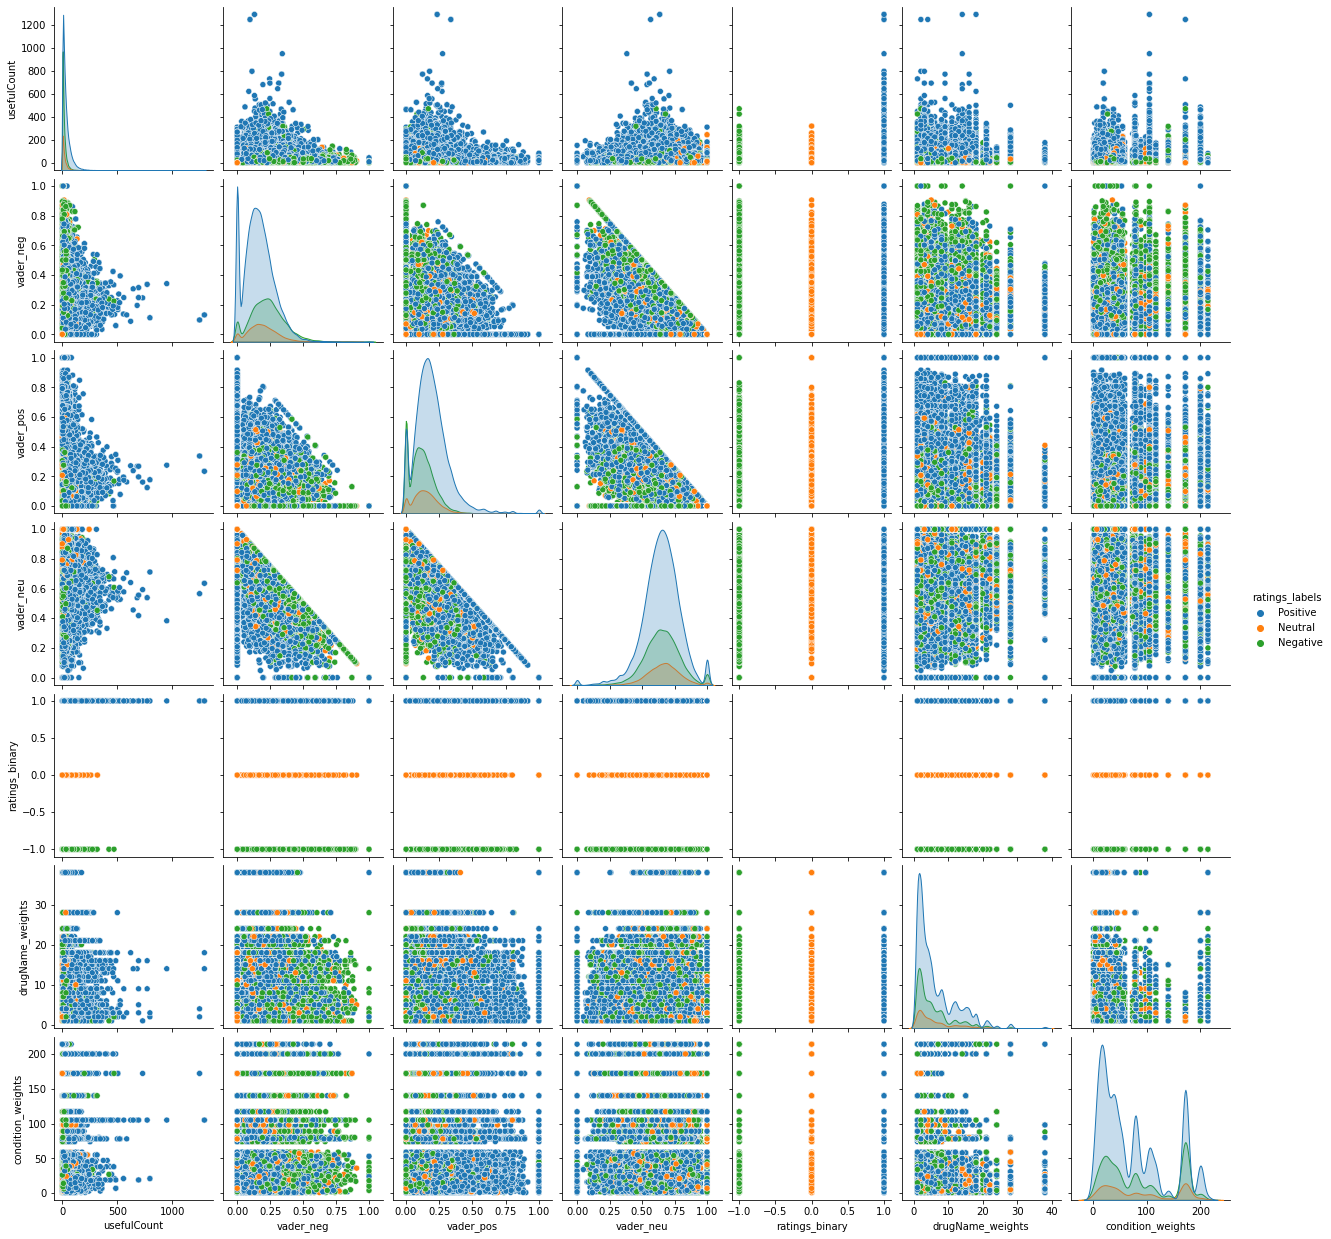

In [39]:
sns.pairplot(df_model, hue='ratings_labels')

The pairplot and heatmaps indicate that the class labels are difficult to differentiate, making it difficult to model the data using traditional machine learning algorithms. We chose the Random Forest classifier because ensemble models in n-D space function well with label boundaries that aren't clearly discernible.

In [40]:
df_model.drop(['drugName', 
               'condition', 
               'ratings_binary'], axis = 1, inplace = True) # dropping the non required columns

### 3. Modeling

Because of the structure of our dataset, as indicated previously, we choose to utilize an ensamble classifier. Our target class label is severely umbalanced.

We use different upsampling strategies to balance our data and produce decent results.

In [41]:
df_model['ratings_labels'].value_counts()

Positive    105749
Negative     39588
Neutral      14161
Name: ratings_labels, dtype: int64

In [42]:
from sklearn.utils import resample

positive_sample = df_model[df_model['ratings_labels'] == 'Positive']
negative_sample = df_model[df_model['ratings_labels'] == 'Negative']
neutral_sample = df_model[df_model['ratings_labels'] == 'Neutral']

# Upsample negative class
negative_upsample = resample(negative_sample,
             replace=True,
             n_samples=len(positive_sample),
             random_state=42)

# Upsample neutral class
neutral_upsample = resample(neutral_sample,
             replace=True,
             n_samples=len(positive_sample),
             random_state=42)

In [43]:
df_model = pd.concat([positive_sample, negative_upsample, neutral_upsample])
df_model.shape

(317247, 8)

Now that we have our data ready for modeling, we can split the data into test and train. We use the sklearn's library below to get this.

In [44]:
X = df_model[['usefulCount', 'processed_review', 'vader_neg', 'vader_pos',
       'vader_neu','drugName_weights', 'condition_weights']]
Y = df_model[['ratings_labels']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y, random_state = 101)

Before we train our model, we may now pre-process the data. The strategy we used was as follows:

* Text Data: vectorized the text on the train data, then used the same vectorizer to transform the unknowable test data.
* Numeric Data: On the train data, we used a Min-Max scaler to scale the numeric data, and we used the same scaler to modify the test data.

As a result, we were able to ensure that data leakage from the unseen test data did not occur in our modeling pipeline.

In [45]:
from sklearn import preprocessing

# Scaling drugName_weights and condition_weights

scaler_drugName_weights = preprocessing.MinMaxScaler()
scaler_condition_weights = preprocessing.MinMaxScaler()

X_train['drugName_weights_scaled'] = scaler_drugName_weights.fit_transform(X_train['drugName_weights'].values.reshape(-1,1))
X_train['condition_weights_scaled'] = scaler_condition_weights.fit_transform(X_train['condition_weights'].values.reshape(-1,1))

X_test['drugName_weights_scaled'] = scaler_drugName_weights.transform(X_test['drugName_weights'].values.reshape(-1,1))
X_test['condition_weights_scaled'] = scaler_condition_weights.transform(X_test['condition_weights'].values.reshape(-1,1))


In [46]:
X_test.drop(['drugName_weights', 'condition_weights'], axis = 1, inplace = True)  # dropping unscaled columns
X_test.head()

usefulCount                                   processed_review  \
63622             6  want start say insert realli not pain peopl sa...   
122360           14  start pill excit stop right middl pack mean no...   
128383           75  not sure rate drug keep cancer away might get ...   
10490             8   not help crave chocol time not worth 75 00 month   
46173             5  wors birth control take 2 week alreadi experie...   

        vader_neg  vader_pos  vader_neu  drugName_weights_scaled  \
63622       0.258      0.220      0.523                 0.000000   
122360      0.239      0.175      0.586                 0.189189   
128383      0.312      0.083      0.606                 0.081081   
10490       0.329      0.000      0.671                 0.027027   
46173       0.371      0.057      0.572                 0.135135   

        condition_weights_scaled  
63622                   0.802817  
122360                  0.342723  
128383                  0.093897  
10490                   0.173709  
46173                   0.802817

In [47]:
X_train.drop(['drugName_weights', 'condition_weights'], axis = 1, inplace = True) # dropping unscaled columns
X_train.head() 

usefulCount                                   processed_review  \
2963            11          much better sr still need coupl anoth med   
43807            0  last period began oct 26 30 howev got realli d...   
46468           92  taken 30mg sever year work well first slept we...   
96606            5  took natazia 4 month take levora portia 2 year...   
27379            5  birth control 3 month not period gain 10 lb fa...   

       vader_neg  vader_pos  vader_neu  drugName_weights_scaled  \
2963       0.000      0.293      0.707                 0.081081   
43807      0.220      0.028      0.752                 0.000000   
46468      0.102      0.169      0.730                 0.000000   
96606      0.032      0.208      0.759                 0.027027   
27379      0.525      0.000      0.475                 0.189189   

       condition_weights_scaled  
2963                   0.488263  
43807                  0.051643  
46468                  0.361502  
96606                  0.802817  
27379                  0.802817

In [48]:
scaler_usefulCount = preprocessing.MinMaxScaler() # Scaling usefulCount

X_train['usefulCount_scaled'] = scaler_usefulCount.fit_transform(X_train['usefulCount'].values.reshape(-1,1))
X_test['usefulCount_scaled'] = scaler_usefulCount.transform(X_test['usefulCount'].values.reshape(-1,1))

In [49]:
X_train.drop(['usefulCount'], axis = 1, inplace = True) # dropping unscaled columns
X_train.head()

processed_review  vader_neg  \
2963           much better sr still need coupl anoth med      0.000   
43807  last period began oct 26 30 howev got realli d...      0.220   
46468  taken 30mg sever year work well first slept we...      0.102   
96606  took natazia 4 month take levora portia 2 year...      0.032   
27379  birth control 3 month not period gain 10 lb fa...      0.525   

       vader_pos  vader_neu  drugName_weights_scaled  \
2963       0.293      0.707                 0.081081   
43807      0.028      0.752                 0.000000   
46468      0.169      0.730                 0.000000   
96606      0.208      0.759                 0.027027   
27379      0.000      0.475                 0.189189   

       condition_weights_scaled  usefulCount_scaled  
2963                   0.488263            0.008521  
43807                  0.051643            0.000000  
46468                  0.361502            0.071263  
96606                  0.802817            0.003873  
27379                  0.802817            0.003873

In [50]:
X_test.drop(['usefulCount'], axis = 1, inplace = True)  # dropping unscaled columns
X_test.head()

processed_review  vader_neg  \
63622   want start say insert realli not pain peopl sa...      0.258   
122360  start pill excit stop right middl pack mean no...      0.239   
128383  not sure rate drug keep cancer away might get ...      0.312   
10490    not help crave chocol time not worth 75 00 month      0.329   
46173   wors birth control take 2 week alreadi experie...      0.371   

        vader_pos  vader_neu  drugName_weights_scaled  \
63622       0.220      0.523                 0.000000   
122360      0.175      0.586                 0.189189   
128383      0.083      0.606                 0.081081   
10490       0.000      0.671                 0.027027   
46173       0.057      0.572                 0.135135   

        condition_weights_scaled  usefulCount_scaled  
63622                   0.802817            0.004648  
122360                  0.342723            0.010844  
128383                  0.093897            0.058095  
10490                   0.173709            0.006197  
46173                   0.802817            0.003873

During our EDA, we discovered that 3-grams and 4-grams in the reviews kept the context significantly better. We chose to employ the tf-idf vectorizer with only 3-grams and 4-grams to aid our model in preserving the context observed by a human.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf-idf vectorizer

tfidf_drugName = TfidfVectorizer(min_df=10, ngram_range=(3,4))
X_train_review = tfidf_drugName.fit_transform(X_train['processed_review'].values)
X_train_review.shape

(212555, 263625)

In [52]:
X_test_review = tfidf_drugName.transform(X_test['processed_review'].values) # transform on test data
X_test_review.shape

(104692, 263625)

In [53]:
X_train.drop(['processed_review'], axis = 1, inplace = True) # dropping reviews column
X_train.head()

vader_neg  vader_pos  vader_neu  drugName_weights_scaled  \
2963       0.000      0.293      0.707                 0.081081   
43807      0.220      0.028      0.752                 0.000000   
46468      0.102      0.169      0.730                 0.000000   
96606      0.032      0.208      0.759                 0.027027   
27379      0.525      0.000      0.475                 0.189189   

       condition_weights_scaled  usefulCount_scaled  
2963                   0.488263            0.008521  
43807                  0.051643            0.000000  
46468                  0.361502            0.071263  
96606                  0.802817            0.003873  
27379                  0.802817            0.003873

In [54]:
X_test.drop(['processed_review'], axis = 1, inplace = True) # dropping reviews column
X_test.head()

vader_neg  vader_pos  vader_neu  drugName_weights_scaled  \
63622       0.258      0.220      0.523                 0.000000   
122360      0.239      0.175      0.586                 0.189189   
128383      0.312      0.083      0.606                 0.081081   
10490       0.329      0.000      0.671                 0.027027   
46173       0.371      0.057      0.572                 0.135135   

        condition_weights_scaled  usefulCount_scaled  
63622                   0.802817            0.004648  
122360                  0.342723            0.010844  
128383                  0.093897            0.058095  
10490                   0.173709            0.006197  
46173                   0.802817            0.003873

To generate our training and testing datasets, we can now stack our numeric scaled data and our tf-idf vectorized data. We need to double-check that the test and train vectors' columns are same.

In [55]:
from scipy.sparse import hstack

train_vector = hstack((X_train, X_train_review)).tocsr()
test_vector = hstack((X_test, X_test_review)).tocsr()

In [56]:
test_vector.shape[1] == train_vector.shape[1] 

True

Now, our vectorized and upsampled data to train our model using a Random Forest Classifer, an ensemble machine learning model. The Random Forest Classifer was trained with best parameters we got during GridSearch Cross-Validation. 

In [57]:
# param_grid = {'n_estimators': [100,200,1000],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [2,4,10,20],
#                'min_samples_split': [2, 5],
#                'min_samples_leaf': [1, 2],
#                'bootstrap': [True, False]}
# rf_Model = RandomForestClassifier()
# from sklearn.model_selection import GridSearchCV
# rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
# rf_Grid.fit(X_train_vectorized, y_train)

In [58]:
# Training our model with the best parameters

rf = RandomForestClassifier(bootstrap=True, criterion='gini', max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)    
rf.fit(train_vector, y_train)

Because upsampled data makes training time consuming, we trained the model and saved the model checkpoint as a pickle file that can be loaded at any time to make predictions on test data.

In [59]:
# Download: https://uofi.box.com/s/iy5osiymhs4ab4f93u0coymnex7tbxfs

import pickle
with open('rf_classifier_drugReviews.pkl', 'rb') as f:
    model = pickle.load(f)

### 4. Performance Metrics

Predicting on test data and generating the performance metrics to observe the performance for each label category

In [60]:
from sklearn.metrics import accuracy_score

# accuracy
predictions = model.predict(test_vector)
print('Acurracy: ', accuracy_score(y_test, predictions))

Acurracy:  0.9651549306537271


In [61]:
from sklearn.metrics import classification_report

# Classification Report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95     34897
     Neutral       1.00      1.00      1.00     34898
    Positive       0.96      0.94      0.95     34897

    accuracy                           0.97    104692
   macro avg       0.97      0.97      0.97    104692
weighted avg       0.97      0.97      0.97    104692



In [62]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, predictions, labels=['Negative', 'Neutral', 'Positive'])

cm_df = pd.DataFrame({'negative': [cm[0][0], cm[1][0], cm[2][0]], 
                 'neutral': [cm[0][1], cm[1][1], cm[2][1]], 
                 'positive': [cm[0][2], cm[1][2], cm[2][2]]})
cm_df.index = ['negative', 'neutral', 'positive']
cm_df

negative  neutral  positive
negative     33505        5      1387
neutral         44    34776        78
positive      2097       37     32763

Our model performed well 95.72% true positive and 93.99% true negative rates. However, due to upsampling overfitting might have caused the true neutral rates to be at an unrealistic 99.88%. Perhaps this could be avoided if we had more data in the neutral class.

Text(51.0, 0.5, 'Predicted Labels')

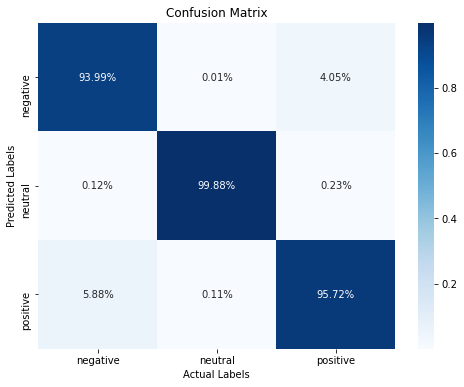

In [63]:
fig, ax = plt.subplots(figsize=(8,6))  

sns.heatmap(cm_df/np.sum(cm_df),
            annot=True, 
            fmt='.2%', 
            cmap='Blues', 
            ax=ax)

plt.title('Confusion Matrix')
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")

### 5. Conclusion

We identified the top drugs for each condition based on the drug review data, assessed the sentiment, and determined which drugs are most recommended by users for common conditions. Finally, we created a supervised sentiment analysis classifier model that will recommend a medicine that has a positive sentiment for a certain disease based on user reviews.

### 6. Future Scope

In order to distinguish the classes better, we could have done better feature transforms that yielded separations. For example:

* Punish the usefulCount for Negative reviews by assigning a negative value, while keeping the positive reviews as is
* Experiment with polynomial or kernel based feature engineering 
* Use the date column in conjunction with the usefulCount by assigning higher weights to newer reviews to reduce bias, as older reviews may have more counts.